# Experimentación - AGCRN



## 1. Obtención de datos



In [1]:

import torch
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
import networkx as nx
sns.set_palette("coolwarm_r")
import matplotlib.pyplot as plt
import numpy as np

from torch_geometric.data import Data, Dataset
from torch_geometric.nn import GCNConv
import itertools
import os, sys

path = os.getcwd()

sys.path.insert(1, "/".join(path.split("/")[0:-1]))

from utils import powergrid


from utils import pygt_loader

try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable
import os
import torch

from utils.models import AGCRNModel
from utils.trainer import  TrainerAGCRN
from utils.utils_graph import *
dtype = torch.float
device = torch.device("cpu")

In [12]:
from importlib import reload
import utils.models
utils.models = reload(utils.models)
from utils.models import MPNNLSTMModel

In [2]:
#folder_path = "/home/TFM/code_dataset2/datos/Natural Oscillation"
folder_path = "/Users/maguado/Documents/UGR/Master/TFM/datos_2/Natural Oscillation"

In [3]:
loader = powergrid.PowerGridDatasetLoader(folder_path, problem="classification_type")
_,_,_ =loader.process()
limit = 300
dataset_full, situations_each = loader.get_dataset()
target_names = loader.target_names

Processing dataset...
Processing:  row_307
Node:  0  not included, including...
Node:  1  not included, including...
Node:  2  not included, including...
Node:  3  not included, including...
Node:  4  not included, including...
Node:  5  not included, including...
Node:  6  not included, including...
Node:  7  not included, including...
Node:  8  not included, including...
Node:  9  not included, including...
Node:  10  not included, including...
Node:  11  not included, including...
Node:  12  not included, including...
Node:  13  not included, including...
Node:  14  not included, including...
Node:  15  not included, including...
Node:  16  not included, including...
Node:  17  not included, including...
Node:  18  not included, including...
Node:  19  not included, including...
Node:  20  not included, including...
Node:  21  not included, including...
Node:  22  not included, including...
Processing:  row_135
Processing:  row_75
Processing:  row_338
Processing:  row_81
Processing:

## Funciones auxiliares - entrenamiento

In [43]:
def entrenar_y_evaluar_modelos_agcrn(param_grid, dataset, dataloader_params, num_early_stop, num_epochs, problem="Classification", name=None, target_names=None):
    resultados_list = []

    # Variables para guardar el mejor modelo
    mejor_loss_test = float('inf')
    mejor_trainer = None
    mejores_parametros = None
    mejores_resultados = None

    # Detalles del dataset
    n_nodes = dataset.features[0].shape[0]
    n_target = dataset.targets[0].shape[0]
    n_features = dataset[0].x.shape[1]

    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

    for hidden, embedding, k in tqdm(list(itertools.product(param_grid["hidden_size"], param_grid["embedding"], param_grid["k"]))):
        

        model = AGCRNModel(n_features=n_features, n_nodes=n_nodes, embedding_dim=embedding,hidden_size = hidden, k=k, n_target=n_target, name="AGCRN", is_classification=True)
        trainer = TrainerAGCRN(model, dataset, device, f"../experimentos_split/results/{problem}", dataloader_params, is_classification = True)

        losses, eval_losses, accs, precisions, recalls, f1s = trainer.train(num_epochs=num_epochs, steps=50, num_early_stop=num_early_stop)
        test_acc, test_precision, test_recall, test_f1, test_loss, preds, real = trainer.test()

        results_intermedio = {
            "Embedding": embedding,
            "Hidden": hidden,   
            "k": k,
            "Loss_final": losses[-1],  # Usando el último valor de la lista, si es consistente con tus datos
            "Accuracy_eval": np.mean(accs),
            "Precision_eval": np.mean(precisions),
            "Recall_eval": np.mean(recalls),
            "F1_eval": np.mean(f1s),
            "Loss_eval": np.mean(eval_losses[-1]),  # Asumiendo que tienes evaluaciones periódicas como en regresión
            "Loss_tst": np.mean(test_loss),
            "Accuracy_tst": test_acc,
            "Precision_tst": test_precision,
            "Recall_tst": test_recall,
            "F1_tst": test_f1
        }
        
        resultados_list.append(results_intermedio)

        # Actualizar el mejor modelo si es necesario
        if np.mean(test_loss) < mejor_loss_test:
            mejor_loss_test = np.mean(test_loss)
            mejor_trainer = trainer
            mejores_parametros = {'hidden': hidden, "Embedding": embedding, 'K': k}
            mejores_resultados = results_intermedio

        print("Parámetros: ", hidden, k, embedding)
        print("Resultados: ", resultados_list[-1])

    resultados_df = pd.DataFrame(resultados_list)
    return mejor_trainer, mejores_parametros, mejores_resultados, resultados_df


## Bucle rápido para ajustar y guardar resultados

In [47]:
from importlib import reload
import utils.models
utils.models = reload(utils.models)
from utils.models import AGCRNModel

In [48]:
from importlib import reload
import utils.trainer
utils.trainer = reload(utils.trainer)
from utils.trainer import TrainerAGCRN

In [50]:

param_grid = {
    "hidden_size": [10,20,50],
    "embedding": [3,5, 10, 15], 
    "k": [2, 3, 4]
}

dataloader_params = {
    "batch_size": 4,
    "data_split_ratio": [0.7, 0.15, 0.15],
    "seed": 42,
    "keep_same": True,
    "use_batch": True
}

num_early_stop = 10
num_epochs = 100
problem = "clasificacion"

mejor_trainer, mejores_parametros, mejores_resultados, resultados_df = entrenar_y_evaluar_modelos_agcrn(
    param_grid, 
    dataset_full, 
    dataloader_params, 
    num_early_stop, 
    num_epochs, 
    problem, "AGCRN",target_names)

  0%|          | 0/36 [00:00<?, ?it/s]


==================== DATASET INFO ===================

Train dataset: 390
Validation dataset: 75
Test dataset: 84

==================== DATALOADER INFO ===================

DataLoader for train set:
Number of batches: 97
DataLoader for val set:
Number of batches: 18
DataLoader for test set:
Number of batches: 21

==================== TRAIN INFO ===================

Epoch 1/100 | Train Loss: 1.5816 | Eval Loss: 1.5412 | Accuracy: 0.4028 | Precision: 0.0806 | Recall: 0.2000 | F1-Score: 0.1149 | LR: 0.0010 | 
Epoch 2/100 | Train Loss: 1.5579 | Eval Loss: 1.5132 | Accuracy: 0.4028 | Precision: 0.0806 | Recall: 0.2000 | F1-Score: 0.1149 | LR: 0.0010 | 
Epoch 3/100 | Train Loss: 1.5418 | Eval Loss: 1.4903 | Accuracy: 0.4028 | Precision: 0.0806 | Recall: 0.2000 | F1-Score: 0.1149 | LR: 0.0010 | 
Epoch 4/100 | Train Loss: 1.5297 | Eval Loss: 1.4738 | Accuracy: 0.4028 | Precision: 0.0806 | Recall: 0.2000 | F1-Score: 0.1149 | LR: 0.0010 | 
Epoch 5/100 | Train Loss: 1.5176 | Eval Loss: 1.4576 | 

  3%|▎         | 1/36 [01:27<51:13, 87.81s/it]

              precision    recall  f1-score   support

           0       0.64      0.75      0.69        12
           1       0.38      0.73      0.50        15
           2       0.43      0.33      0.38         9
           3       0.00      0.00      0.00        19
           4       0.71      0.83      0.76        29

    accuracy                           0.56        84
   macro avg       0.43      0.53      0.47        84
weighted avg       0.45      0.56      0.49        84

preds:  ()
test loss: 1.360325, test accuracy: 0.5595, test precision: 0.4313, test recall: 0.5289, test F1-score: 0.4658
Parámetros:  10 2 3
Resultados:  {'Embedding': 3, 'Hidden': 10, 'k': 2, 'Loss_final': 1.2972253561019897, 'Accuracy_eval': 0.5665064102564101, 'Precision_eval': 0.27697298618343447, 'Recall_eval': 0.41682309732707606, 'F1_eval': 0.3231159276112126, 'Loss_eval': 1.3019384145736694, 'Loss_tst': 1.3603248596191406, 'Accuracy_tst': 0.5595238095238095, 'Precision_tst': 0.4313242538394668, 'R

  6%|▌         | 2/36 [03:20<57:54, 102.19s/it]

              precision    recall  f1-score   support

           0       0.63      1.00      0.77        12
           1       0.37      0.73      0.49        15
           2       1.00      0.11      0.20         9
           3       0.00      0.00      0.00        19
           4       0.71      0.83      0.76        29

    accuracy                           0.57        84
   macro avg       0.54      0.53      0.44        84
weighted avg       0.51      0.57      0.48        84

preds:  ()
test loss: 1.355682, test accuracy: 0.5714, test precision: 0.5408, test recall: 0.5344, test F1-score: 0.4450
Parámetros:  10 3 3
Resultados:  {'Embedding': 3, 'Hidden': 10, 'k': 3, 'Loss_final': 1.3164836168289185, 'Accuracy_eval': 0.5758547008547008, 'Precision_eval': 0.27600483666063236, 'Recall_eval': 0.4295721961504454, 'F1_eval': 0.33292134361536735, 'Loss_eval': 1.3018372058868408, 'Loss_tst': 1.3556815385818481, 'Accuracy_tst': 0.5714285714285714, 'Precision_tst': 0.5408255933952528, 'R

  8%|▊         | 3/36 [05:07<57:29, 104.54s/it]

              precision    recall  f1-score   support

           0       0.63      1.00      0.77        12
           1       0.44      0.47      0.45        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.57      0.97      0.72        29

    accuracy                           0.56        84
   macro avg       0.33      0.49      0.39        84
weighted avg       0.37      0.56      0.44        84

preds:  ()
test loss: 1.374439, test accuracy: 0.5595, test precision: 0.3281, test recall: 0.4864, test F1-score: 0.3888
Parámetros:  10 4 3
Resultados:  {'Embedding': 3, 'Hidden': 10, 'k': 4, 'Loss_final': 1.3638447523117065, 'Accuracy_eval': 0.548344017094017, 'Precision_eval': 0.2308545969417304, 'Recall_eval': 0.37985558502799877, 'F1_eval': 0.2840738713650979, 'Loss_eval': 1.3206859827041626, 'Loss_tst': 1.3744393587112427, 'Accuracy_tst': 0.5595238095238095, 'Precision_tst': 0.3281015037593985, 'Rec

 11%|█         | 4/36 [06:31<51:33, 96.66s/it] 

              precision    recall  f1-score   support

           0       0.52      1.00      0.69        12
           1       0.39      0.73      0.51        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.73      0.83      0.77        29

    accuracy                           0.56        84
   macro avg       0.33      0.51      0.39        84
weighted avg       0.40      0.56      0.46        84

preds:  ()
test loss: 1.363903, test accuracy: 0.5595, test precision: 0.3284, test recall: 0.5122, test F1-score: 0.3943
Parámetros:  10 2 5
Resultados:  {'Embedding': 5, 'Hidden': 10, 'k': 2, 'Loss_final': 1.3073426485061646, 'Accuracy_eval': 0.5731837606837606, 'Precision_eval': 0.2845889285621909, 'Recall_eval': 0.43857942823460055, 'F1_eval': 0.3397460393161321, 'Loss_eval': 1.3018351793289185, 'Loss_tst': 1.3639030456542969, 'Accuracy_tst': 0.5595238095238095, 'Precision_tst': 0.32837380011293055, 'R

 14%|█▍        | 5/36 [08:15<51:12, 99.10s/it]

              precision    recall  f1-score   support

           0       0.63      1.00      0.77        12
           1       0.32      0.73      0.45        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.68      0.72      0.70        29

    accuracy                           0.52        84
   macro avg       0.33      0.49      0.38        84
weighted avg       0.38      0.52      0.43        84

preds:  ()
test loss: 1.386173, test accuracy: 0.5238, test precision: 0.3265, test recall: 0.4915, test F1-score: 0.3846
Parámetros:  10 3 5
Resultados:  {'Embedding': 5, 'Hidden': 10, 'k': 3, 'Loss_final': 1.342650294303894, 'Accuracy_eval': 0.5673076923076923, 'Precision_eval': 0.24575181675239127, 'Recall_eval': 0.39917023736652385, 'F1_eval': 0.30164539760553305, 'Loss_eval': 1.31233549118042, 'Loss_tst': 1.3861732482910156, 'Accuracy_tst': 0.5238095238095238, 'Precision_tst': 0.3265055427943673, 'Rec

 17%|█▋        | 6/36 [10:05<51:22, 102.75s/it]

              precision    recall  f1-score   support

           0       0.57      1.00      0.73        12
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.46      1.00      0.63        29

    accuracy                           0.49        84
   macro avg       0.21      0.40      0.27        84
weighted avg       0.24      0.49      0.32        84

preds:  ()
test loss: 1.416632, test accuracy: 0.4881, test precision: 0.2063, test recall: 0.4000, test F1-score: 0.2715
Parámetros:  10 4 5
Resultados:  {'Embedding': 5, 'Hidden': 10, 'k': 4, 'Loss_final': 1.4061787128448486, 'Accuracy_eval': 0.5459401709401709, 'Precision_eval': 0.20886944915370545, 'Recall_eval': 0.3585798816568047, 'F1_eval': 0.26143611464629884, 'Loss_eval': 1.3372055292129517, 'Loss_tst': 1.4166322946548462, 'Accuracy_tst': 0.4880952380952381, 'Precision_tst': 0.20634920634920634, '


==================== TEST INFO ===================

              precision    recall  f1-score   support

           0       0.80      0.67      0.73        12
           1       0.50      0.56      0.53         9
           2       0.33      0.33      0.33         6
           3       1.00      1.00      1.00        16
           4       0.77      0.81      0.79        21

    accuracy                           0.75        64
   macro avg       0.68      0.67      0.68        64
weighted avg       0.76      0.75      0.75        64

preds:  ()
test loss: 1.159883, test accuracy: 0.7500, test precision: 0.6812, test recall: 0.6730, test F1-score: 0.6755


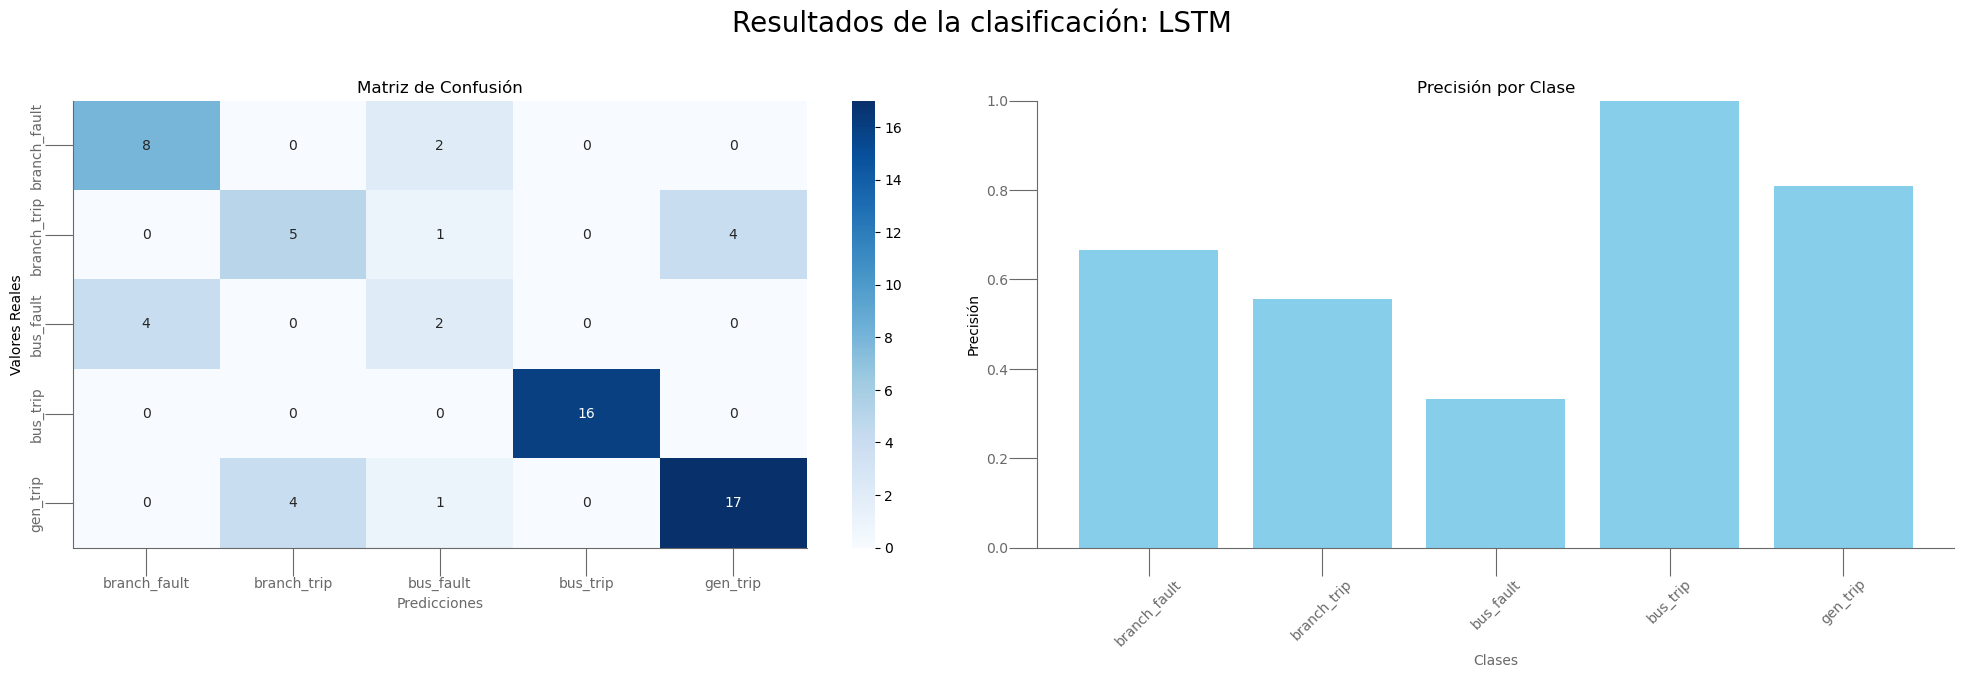

In [ ]:
test_acc, test_precision, test_recall, test_f1, test_loss, preds, real = mejor_trainer.test()
plot_clasificacion(real, preds, target_names, "AGCRN")

In [ ]:
name_model ="AGCRN"
results_save_path = "../experimentos_split/results"

path_save_experiment = results_save_path+f"/{problem}"+ f"/ajustes/{name_model}_results.csv"
resultados_df.to_csv(path_save_experiment, index=False)
mejor_trainer.save_model(path_save_experiment=path_save_experiment, params = mejores_parametros)


==================== GUARDANDO RESULTADOS ===================



RuntimeError: Parent directory ./results/clasificacion does not exist.

## Bucle rápido para ajustar y guardar resultados sin batch

In [ ]:


param_grid = {
    "hidden_size": [50, 100, 150],  
    "n_layers": [1, 2, 3]          
}

dataloader_params = {
    "batch_size": 32,
    "data_split_ratio": [0.7, 0.15, 0.15],
    "seed": 42,
    "keep_same": True,
    "use_batch": False
}

num_early_stop = 10
num_epochs = 100
problem = "clasificacion"

mejor_trainer, mejores_parametros, mejores_resultados, resultados_df = entrenar_y_evaluar_modelos(
    param_grid, 
    dataset_full, 
    dataloader_params, 
    num_early_stop, 
    num_epochs, 
    problem, "LSTM_NOBATCH",target_names)

  0%|          | 0/9 [00:00<?, ?it/s]


==================== DATASET INFO ===================

Train dataset: 390
Validation dataset: 75
Test dataset: 84

==================== DATALOADER INFO ===================

DataLoader for train set:
Number of batches: 12
DataLoader for val set:
Number of batches: 2
DataLoader for test set:
Number of batches: 2

==================== TRAIN INFO ===================

Epoch 1/100 | Train Loss: 1.5357 | Eval Loss: 1.4307 | Accuracy: 0.5156 | Precision: 0.1982 | Recall: 0.3200 | F1-Score: 0.2428 | LR: 0.0010 | 
Epoch 2/100 | Train Loss: 1.4844 | Eval Loss: 1.3876 | Accuracy: 0.5625 | Precision: 0.2147 | Recall: 0.3800 | F1-Score: 0.2741 | LR: 0.0010 | 
Epoch 3/100 | Train Loss: 1.4589 | Eval Loss: 1.3783 | Accuracy: 0.5625 | Precision: 0.2147 | Recall: 0.3800 | F1-Score: 0.2741 | LR: 0.0010 | 
Epoch 4/100 | Train Loss: 1.4450 | Eval Loss: 1.3724 | Accuracy: 0.5625 | Precision: 0.2127 | Recall: 0.3800 | F1-Score: 0.2721 | LR: 0.0010 | 
Epoch 5/100 | Train Loss: 1.4294 | Eval Loss: 1.3555 | Ac

 11%|█         | 1/9 [00:12<01:41, 12.74s/it]

Epoch 52/100 | Train Loss: 1.0792 | Eval Loss: 1.1687 | Accuracy: 0.7500 | Precision: 0.7105 | Recall: 0.7531 | F1-Score: 0.7235 | LR: 0.0010 | 

==================== TEST INFO ===================

              precision    recall  f1-score   support

           0       0.67      0.17      0.27        12
           1       0.60      0.67      0.63         9
           2       0.23      0.50      0.32         6
           3       1.00      1.00      1.00        16
           4       0.77      0.81      0.79        21

    accuracy                           0.69        64
   macro avg       0.65      0.63      0.60        64
weighted avg       0.73      0.69      0.68        64

preds:  ()
test loss: 1.204388, test accuracy: 0.6875, test precision: 0.6540, test recall: 0.6286, test F1-score: 0.6009
Parámetros:  50 1
Resultados:  {'Hidden Size': 50, 'Layers': 1, 'Loss_final': 1.2216247343100035, 'Accuracy': 0.6787860576923077, 'Precision': 0.5670049034763747, 'Recall': 0.6336319307473153


==================== TEST INFO ===================

              precision    recall  f1-score   support

           0       0.80      0.67      0.73        12
           1       0.50      0.56      0.53         9
           2       0.33      0.33      0.33         6
           3       1.00      1.00      1.00        16
           4       0.77      0.81      0.79        21

    accuracy                           0.75        64
   macro avg       0.68      0.67      0.68        64
weighted avg       0.76      0.75      0.75        64

preds:  ()
test loss: 1.159883, test accuracy: 0.7500, test precision: 0.6812, test recall: 0.6730, test F1-score: 0.6755


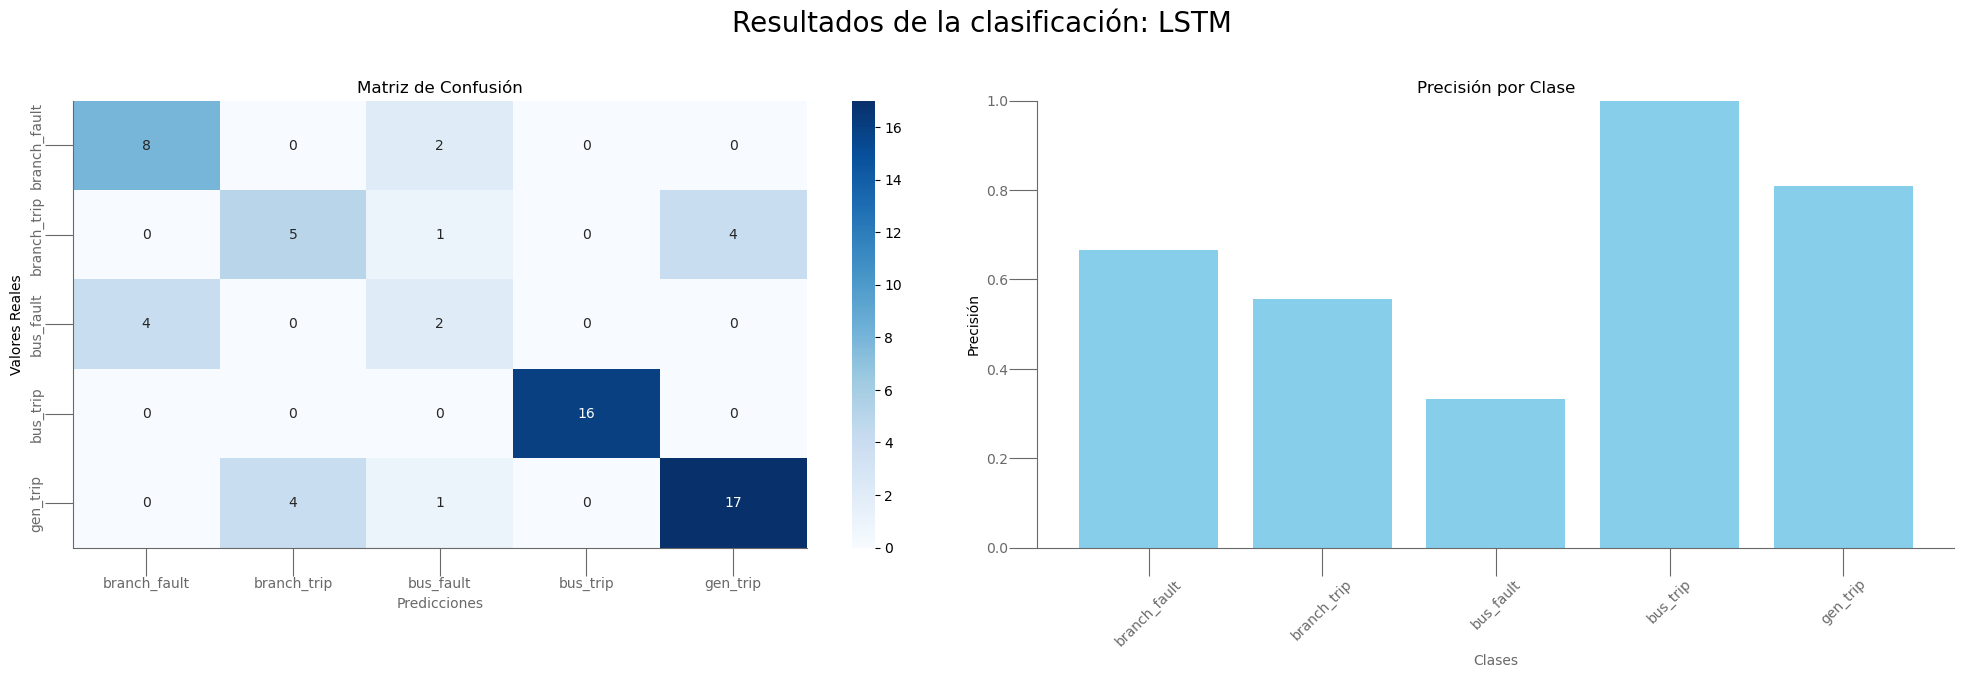

In [ ]:
test_acc, test_precision, test_recall, test_f1, test_loss, preds, real = mejor_trainer.test()
plot_clasificacion(real, preds, target_names, "LSTM")

In [ ]:
name_model ="LSTM_BATCH"
results_save_path = "../experimentos_split/results"

path_save_experiment = results_save_path+f"/{problem}"+ f"/ajustes/{name_model}_results.csv"
resultados_df.to_csv(path_save_experiment, index=False)
mejor_trainer.save_model(path_save_experiment=path_save_experiment, params = mejores_parametros)


==================== GUARDANDO RESULTADOS ===================



RuntimeError: Parent directory ./results/Classification does not exist.